In [1]:
from polar_codes.polar_code import PolarCode
from polar_codes.channels.bpsk_awgn_channel import BpskAwgnChannel
import numpy as np
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from tqdm import tqdm
import pickle
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(512, 256)
        self.act1 = nn.Hardswish ()
        self.bn1 = nn.BatchNorm1d(256, momentum=0.9999)

        self.lin2 = nn.Linear(256, 128)
        self.act2 = nn.Hardswish ()
        self.bn2 = nn.BatchNorm1d(128, momentum=0.9999)

        self.lin3 = nn.Linear(128, 64)
        self.act3 = nn.Hardswish()
        self.bn3 = nn.BatchNorm1d(64, momentum=0.9999)

        self.lin4 = nn.Linear(64, 62)

    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.bn1(x)
        # x = self.drop1(x)

        x = self.lin2(x)
        x = self.act2(x)
        x = self.bn2(x)
        #x = self.drop2(x)

        x = self.lin3(x)
        x = self.act3(x)
        x = self.bn3(x)
        #x = self.drop3(x)

        x = self.lin4(x)
        return x



In [3]:
class conv(nn.Module):

    def __init__(self):
        super(conv, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 8)
        self.act1 = nn.Hardswish()
        self.pool1 = nn.MaxPool1d(8, 8)
        self.bn1 = nn.BatchNorm1d(16, momentum=0.9999)

        self.conv2 = nn.Conv1d(16, 32, 8)
        self.act2 = nn.Hardswish()
        self.pool2 = nn.MaxPool1d(8, 8)
        self.bn2 = nn.BatchNorm1d(32, momentum=0.9999)


        self.lin1 = nn.Linear(224, 128)
        self.act3 = nn.Hardswish()
        self.bn3 = nn.BatchNorm1d(128, momentum=0.9999)
        
        self.lin2 = nn.Linear(128, 62)



    def forward(self, x):
        x  = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.bn2(x)

        x = x.view(-1, 224)

        x = self.lin1(x)
        x = self.act3(x)
        x = self.bn3(x)

        x = self.lin2(x)
        return x

In [4]:
model1 = Net()
model1.load_state_dict(torch.load('polar_linear_model.pth', map_location=torch.device('cpu')))
model1.eval()
model1.double();

In [5]:
model2 = conv()
model2.load_state_dict(torch.load('polar_conv.pth', map_location=torch.device('cpu')))
model2.eval()
model2.double();

In [6]:
def predict(model, X, conv=False):
    X = X.copy()
    classes = [121, 111, 118, 119, 159, 179, 122, 171, 117, 174, 124, 123, 203,
             158, 173, 216, 206, 181, 185, 188, 225, 182, 211, 232, 205, 286,
             186, 199, 212, 228, 285, 312, 240, 226, 283, 295, 213, 306, 301,
             299, 279, 329, 307, 337, 354, 330, 308, 332, 327, 387, 393, 353,
             338, 394, 390, 302, 389, 344, 340, 396, 416, 448]
    with torch.no_grad():
        X = (X+45.175924783430474)/757.9691984444514
        X = torch.tensor(X).double().unsqueeze(0)
        if conv:
            X = X.unsqueeze(1)
        pred = model(X).numpy()
        pred = list(np.argsort(pred)[0, -20:])[::-1]
        bits = []
    for i in range(len(pred)):
        bits.append(classes[pred[i]])
    return bits

In [ ]:
def predict_lstm(model, X):
    X = X.copy()
    classes = [121, 111, 118, 119, 159, 179, 122, 171, 117, 174, 124, 123, 203,
             158, 173, 216, 206, 181, 185, 188, 225, 182, 211, 232, 205, 286,
             186, 199, 212, 228, 285, 312, 240, 226, 283, 295, 213, 306, 301,
             299, 279, 329, 307, 337, 354, 330, 308, 332, 327, 387, 393, 353,
             338, 394, 390, 302, 389, 344, 340, 396, 416, 448]
    with torch.no_grad():
        X = (X+45.175924783430474)/757.9691984444514
        X = torch.tensor(X).double().unsqueeze(0)
        pred = model(X).numpy()
        pred = list(np.argsort(pred)[0, -20:])[::-1]
        bits = []
    for i in range(len(pred)):
        bits.append(classes[pred[i]])
    return bits

In [7]:
class rec_dec:
    def __init__(self, code, y_message, i, u_est, is_calc_llr, llr_array, pm=0, PM=0):
        self.u_est = u_est
        self.is_calc_llr = is_calc_llr
        self.llr_array = llr_array
        self.y_message = y_message
        self.pm = pm #Iddooose metric
        self.layer = i
        self.code = code
        self.PM = PM #paper_metric
    
    def split(self):
        #Создаем 2 копии этого же instance c разными параметрами
        u_right = self.u_est.copy()
        u_opp = self.u_est.copy()
        
        self.llr = self.code._fast_llr(self.layer, self.y_message, self.u_est[:self.layer], self.llr_array, self.is_calc_llr) 
        
        u_right[self.layer] = 0 if self.llr > 0 else 1
        u_opp[self.layer] = 1 - u_right[self.layer]
        
        pm_copy_r = self.pm
        pm_copy_opp = self.pm
        llr_copy = self.llr
        
        layer_copy = self.layer
        
        #calc 2 PM and provide them
        PM_right = np.log(1+np.exp(-(1-2*u_right[self.layer])*self.llr))
        new_PM_right = self.PM+PM_right
        
        PM_opp = np.log(1+np.exp(-(1-2*u_opp[self.layer])*self.llr)) 
        new_PM_opp = self.PM+PM_opp
        
        right = rec_dec(self.code, self.y_message, layer_copy+1, u_right, self.is_calc_llr.copy(), self.llr_array.copy(), pm_copy_r, new_PM_right)
        opp = rec_dec(self.code, self.y_message, layer_copy+1, u_opp, self.is_calc_llr.copy(), self.llr_array.copy(), pm_copy_opp+np.abs(llr_copy), new_PM_opp)
        
        return [right, opp]
    
    def meet_frozen(self):
        self.llr = self.code._fast_llr(self.layer, self.y_message, self.u_est[:self.layer], self.llr_array, self.is_calc_llr) 
        self.u_est[self.layer] = 0
        self.pm += np.abs(self.llr) if (self.llr < 0) else 0 
        self.PM += np.log(1+np.exp(-(1-2*self.u_est[self.layer])*self.llr)) 
        self.layer +=1
    
    def get_pm(self):
        return self.pm
    
    def get_PM(self):
        return self.PM
    
    def get_is_calc(self):
        return self.is_calc_llr
    
    def get_l(self):
        return self.layer
    
    def get_u_est(self):
        return self.u_est
    
    def get_llr_array(self):
        return self.llr_array

In [8]:
def scl_dec(code, y_message, list_size=32, train=None): #we should decide here whether to by Indooose Metric or paper's
    u_est = np.full(code._N, -1)
    is_calc_llr = [False] * code._N * (code._n + 1)
    llr_array = np.full(code._N * (code._n + 1), 0.0, dtype=np.longfloat)
    dec_array = [] # will store L decoders always
    a = rec_dec(code, y_message, 0, u_est, is_calc_llr, llr_array)
    dec_array.append(a)
    M = np.zeros(code._N)
    
    bit_for_flip_train = None
    
    for i in range(code._N): #code._N
        
        if i in code._frozen_bits_positions:
            for elem in dec_array:
                 elem.meet_frozen()
                
        else:
            new_arr = []
            for elem in dec_array:
                temp = elem.split()
                new_arr.append(temp[0])
                new_arr.append(temp[1])
            dec_array = new_arr
            
        
        if len(dec_array) > list_size:
            dec_array.sort(key=lambda x: x.get_PM())
            M[i] = np.sum([x.get_PM() for x in dec_array[list_size:]]) - np.sum([x.get_PM() for x in dec_array[:list_size]])
            
        else:
            M[i] = - np.sum([x.get_PM() for x in dec_array[:list_size]])
        
        if len(dec_array) > list_size:      #pruning from 2L to L decoders
            dec_array.sort(key=lambda x: x.get_PM()) # by paper (mb create new decoder parametr)
            
            if (train is not None) and (bit_for_flip_train is None): #should save i, if right solution among discarded
                
                for inst in dec_array[list_size:]:
                    if (train[:i+1] == inst.get_u_est()[:i+1]).all():
                        bit_for_flip_train = i      
                
            dec_array = dec_array[:list_size] # delete discarded paths
            
    return M, bit_for_flip_train, dec_array

In [9]:
def scl_dec_forced(code, y_message, list_size=32, flipped_bit=None): #we should decide here whether to by Indooose Metric or paper's
    u_est = np.full(code._N, -1)
    is_calc_llr = [False] * code._N * (code._n + 1)
    llr_array = np.full(code._N * (code._n + 1), 0.0, dtype=np.longfloat)
    dec_array = [] # will store L decoders always
    a = rec_dec(code, y_message, 0, u_est, is_calc_llr, llr_array)
    dec_array.append(a)
#    M = np.zeros(code._N)
    
#    bit_for_flip_train = None
    
    for i in range(code._N): #code._N
        
        if i in code._frozen_bits_positions:
            for elem in dec_array:
                 elem.meet_frozen()
                
        else:
            new_arr = []
            for elem in dec_array:
                temp = elem.split()
                new_arr.append(temp[0])
                new_arr.append(temp[1])
            dec_array = new_arr
            
        
        if len(dec_array) > list_size:      #pruning from 2L to L decoders
            dec_array.sort(key=lambda x: x.get_PM()) # by paper (mb create new decoder parametr)
            dec_array = dec_array[:list_size] if i != flipped_bit else dec_array[list_size:] # delete discarded paths
            
    return dec_array

In [26]:
def check_models(sinrdb_i):
    channel = BpskAwgnChannel(sinrdb_i)
    n = 9
    K = 256
    code = PolarCode(n=n, K=K,
                     construction_method='PW',
                     channel=channel, CRC_len=24)

    u_message = np.asarray([0 if np.random.random_sample() > 0.5 else 1 for _ in range(0, K)], dtype='uint8') # x100
    x_message = code.encode(u_message)
    to_message = channel.modulate(x_message)
    from_message = channel.transmit(to_message)
    y_message = channel.demodulate(from_message)
    M, bit, C = scl_dec(code, y_message, 8, code.extend_info_bits(u_message))
    before = 0 in [np.abs(u_message - code.get_message_info_bits(d.get_u_est())).sum() for d in C]
    pos_in_lin_set = 500
    pos_in_conv_set = 500
    is_managed = False
    if before:
        return 0, 0, True, True, True
    #проверяем сходимость CRC ~ наличие бита
    if (bit is not None): #если есть то прогоняем обе модели
        lin_set = predict(model1, M)
        conv_set = predict(model2, M, True)
        
        #записываем в листы есть в ли в предсказанном наборе бит
        is_in_lin_set = bit in lin_set
        is_in_conv_set = bit in conv_set
        is_in_most_frequent = bit in most_frequent_bits
        #и позиции
        pos_in_lin_set = lin_set.index(bit) if is_in_lin_set else 500
        pos_in_conv_set = conv_set.index(bit) if is_in_conv_set else 500
        # если есть то пробуем декодировать с заменой и записываем сошлось ли теперь CRC
        if (is_in_lin_set or is_in_conv_set or is_in_most_frequent):
            decoders = scl_dec_forced(code, y_message, list_size=8, flipped_bit=bit)
            #проверяем на ошибки
            
            is_managed = 0 in [np.abs(u_message - code.get_message_info_bits(d.get_u_est())).sum() for d in decoders]
#! добавить CRC 

        return pos_in_lin_set, pos_in_conv_set, is_in_most_frequent, is_managed, False

In [27]:
sinrsdb = [-0.38918066,  0.11081934,  0.61081934,  1.11081934,  1.61081934]
frequences = [500, 1000, 2000, 7000, 30000]

In [28]:
most_frequent_bits = [117, 118, 111, 121, 122, 158, 171, 173, 124, 174, 179, 119, 181,
159, 279, 283, 225, 199, 226, 212]

In [30]:
usuals = []
frequents = []
conv10 = []
conv15 = []
conv20 = []
lin10 = []
lin15 = []
lin20 = []
for sinr, a in zip(sinrsdb, frequences):
    print(sinr)
    data = Parallel(n_jobs=cpu_count()-1)(delayed(lambda x: check_models(x))(sinr) for _ in range(a))
    data = pd.DataFrame(data, columns=['pos_in_lin_set', 'pos_in_conv_set', 'is_in_most_frequent', 'is_managed',
                                      'before'])
    us = 1- data['before'].mean()
    print('usual=', us)
    usuals.append(us)
    
    fr = 1-(data['is_managed'] & data['is_in_most_frequent']).mean()
    print('fr=', fr)
    frequents.append(fr)
    
    c10 = 1-(data['is_managed'] & (data['pos_in_conv_set'] < 10)).mean()
    c15 = 1-(data['is_managed'] & (data['pos_in_conv_set'] < 15)).mean()
    c20 = 1-(data['is_managed'] & (data['pos_in_conv_set'] < 20)).mean()
    l10 = 1-(data['is_managed'] & (data['pos_in_lin_set'] < 10)).mean()
    l15 = 1-(data['is_managed'] & (data['pos_in_lin_set'] < 15)).mean()
    l20 = 1-(data['is_managed'] & (data['pos_in_lin_set'] < 20)).mean()
    conv10.append(c10)
    conv15.append(c15)
    conv20.append(c20)
    lin10.append(l10)
    lin15.append(l15)
    lin20.append(l20)
    print(f'c10={c10}')
    print(f'c15={c15}')
    print(f'c20={c20}')
    print(f'l10={l10}')
    print(f'l15={l15}')
    print(f'l20={l20}')

-0.38918066
usual= 0.626
fr= 0.6
c10=0.494
c15=0.482
c20=0.46599999999999997
l10=0.514
l15=0.488
l20=0.46199999999999997
0.11081934
usual= 0.267
fr= 0.257
c10=0.17000000000000004
c15=0.15100000000000002
c20=0.138
l10=0.17900000000000005
l15=0.16000000000000003
l20=0.14300000000000002
0.61081934
usual= 0.07499999999999996
fr= 0.07350000000000001
c10=0.03149999999999997
c15=0.02749999999999997
c20=0.025000000000000022
l10=0.03700000000000003
l15=0.028000000000000025
l20=0.026000000000000023
1.11081934
usual= 0.01571428571428568
fr= 0.015428571428571458
c10=0.005428571428571449
c15=0.004857142857142893
c20=0.004428571428571448
l10=0.005714285714285672
l15=0.004714285714285671
l20=0.004428571428571448
1.61081934


KeyboardInterrupt: 

In [29]:
usuals = [0.626, 0.267, 0.07499999999999996, 0.01571428571428568, 0.0018000000000000238]

In [6]:
usuals.append()
frequents.append(0.0018000000000000238)
conv10.append(0.0008000000000000229)
conv15.append(0.0006000000000000449)
conv20.append(0.0006000000000000449)
lin10.append(0.0007000000000000339)
lin15.append(0.0006000000000000449)
lin20.append(0.0004999999999999449)

NameError: name 'usuals' is not defined

In [ ]:
usual= 1.0
fr= 0.544
c10=0.46799999999999997
c15=0.42800000000000005
c20=0.41000000000000003
l10=0.46799999999999997
l15=0.44399999999999995
l20=0.41600000000000004
lstm10=0.562
lstm15=0.56
lstm20=0.554

usual= 1.0
fr= 0.235
c10=0.15600000000000003
c15=0.14600000000000002
c20=0.133
l10=0.16800000000000004
l15=0.14700000000000002
l20=0.14
lstm10=0.243
lstm15=0.238
lstm20=0.23199999999999998

usual= 1.0
fr= 0.06699999999999995
c10=0.03400000000000003
c15=0.02949999999999997
c20=0.027000000000000024
l10=0.03749999999999998
l15=0.02849999999999997
l20=0.026000000000000023
lstm10=0.06799999999999995
lstm15=0.06699999999999995
lstm20=0.0655

usual= 1.0
fr= 0.01471428571428568
c10=0.00728571428571434
c15=0.006571428571428561
c20=0.006285714285714339
l10=0.0077142857142856736
l15=0.006857142857142895
l20=0.006285714285714339
lstm10=0.01471428571428568
lstm15=0.01471428571428568
lstm20=0.014571428571428569

usual= 1.0
fr= 0.0018000000000000238
c10=0.0004999999999999449
c15=0.00046666666666661527
c20=0.0004333333333332856
l10=0.0005333333333333856
l15=0.0004333333333332856
l20=0.0004333333333332856
lstm10=0.0018000000000000238
lstm15=0.0018000000000000238
lstm20=0.0018000000000000238

In [23]:
fr = (0.544, 0.235, 0.06699999999999995, 0.01471428571428568, 0.0018000000000000238)
conv10 = (0.46799999999999997, 0.15600000000000003, 0.03400000000000003, 0.00728571428571434, 0.0004999999999999449)
conv15 = (0.42800000000000005, 0.14600000000000002, 0.02949999999999997, 0.006571428571428561, 0.00046666666666661527)
conv20 = (0.41000000000000003, 0.133, 0.027000000000000024, 0.006285714285714339, 0.0004333333333332856)
lin10 = (0.46799999999999997, 0.16800000000000004, 0.03749999999999998, 0.0077142857142856736, 0.0005333333333333856)
lin15 = (0.44399999999999995, 0.14700000000000002, 0.02849999999999997, 0.006857142857142895, 0.0004333333333332856)
lin20 = (0.41600000000000004, 0.14, 0.026000000000000023, 0.006285714285714339, 0.0004333333333332856)
lstm10 = (0.562, 0.243, 0.06799999999999995, 0.01471428571428568, 0.0018000000000000238)
lstm15 = (0.56, 0.238, 0.06699999999999995, 0.01471428571428568, 0.0018000000000000238)
lstm20 = (0.554, 0.23199999999999998, 0.0655, 0.014571428571428569, 0.0018000000000000238)


In [38]:
(0.01571428571428568 - 0.006285714285714339) / 0.01571428571428568

0.5999999999999958

In [16]:
l16 = (0.53,
0.201,
0.047,
0.0086,0.0006)

In [17]:
l16 = (0.488,
0.2,
0.056,
0.012,
0.00096)


In [12]:
l32 = (0.468,
0.167,
0.03,
0.004,
0.0006)

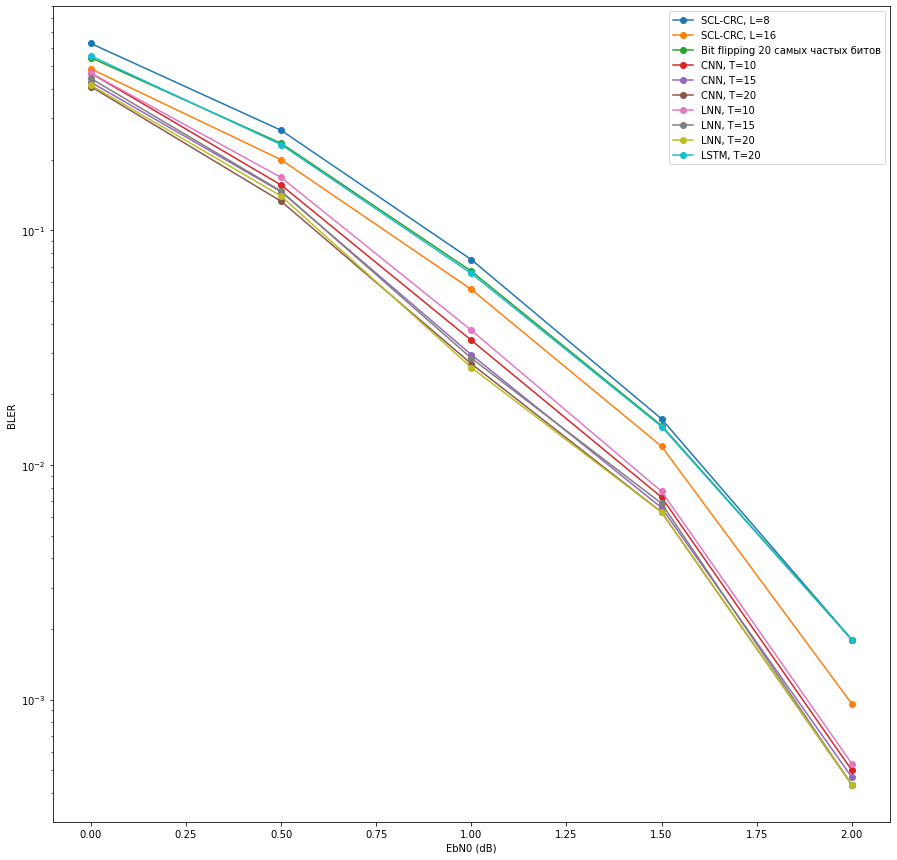

In [32]:
import matplotlib.pyplot as plt
x = np.arange(0, 2.5, 0.5)
plt.figure(figsize=(15, 15))
plt.plot(x, usuals, 'o-', label='SCL-CRC, L=8')
plt.plot(x, l16, 'o-', label='SCL-CRC, L=16')
plt.plot(x, fr, 'o-', label='Bit flipping 20 самых частых битов')
plt.plot(x, conv10, 'o-', label='CNN, T=10')
plt.plot(x, conv15, 'o-', label='CNN, T=15')
plt.plot(x, conv20, 'o-', label='CNN, T=20')
plt.plot(x, lin10, 'o-', label='LNN, T=10')
plt.plot(x, lin15, 'o-', label='LNN, T=15')
plt.plot(x, lin20, 'o-', label='LNN, T=20')
plt.plot(x, lstm20, 'o-', label='LSTM, T=20')

#plt.plot(x, l32, 'o-', label='SCL-CRC, L=32')
#plt.plot([0, 2], [1, 1e-4])
plt.yscale('log')
plt.xlabel('EbN0 (dB)')
plt.ylabel('BLER')
plt.legend()